<a href="https://colab.research.google.com/github/julianovale/PO240_Meta_heuristica/blob/main/PO240_Atividade02_Priscila_GA_Inteira_NA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload() # subir arquivo Instancia

Saving Instancia100.txt to Instancia100.txt


In [ ]:
# importações
%matplotlib inline
import matplotlib.pyplot as plt
import random 
from random import choice
from random import seed
import numpy as np
import time 
import copy
import imageio
import os
from google.colab import files

def leitura(arquivo):
  arq = open(arquivo, "r") # r- read
  lixo = arq.readline()  # linha com texto Number of jobs
  linha = arq.readline() # linha com número de tarefas
  N = int(linha)         # linha com o número de tarefas
  p = np.zeros(N)  # p = [p0, p1,..., p(N-1)]
  w = np.zeros(N)
  d = np.zeros(N)
  lixo = arq.readline()  # linha com texto Job data 
  for i in range(N):  # repetir N vezes
      # i-ésima linha
      linha = arq.readline().split()  # posições: 0-indice, 1-p, 2-w, 3-d
      p[i] = int(linha[1])
      w[i] = int(linha[2])
      d[i] = int(linha[3])
  return N, p, w, d  

# inicializa população aleatoriamente
# cada individuo da populacao terá o seguinte formato:
# [[individuo], [lista com xi], funojb]
# para cada indivíduo i
# populacao[i][0]  para acessar o indivíduo (codificação real ou inteira)
# populacao[i][1]  para acessar a variável de decisão xi
# populacao[i][2]  para acessar a função-objetivo

def inicializaPopulacao(TP, N):
  populacao = []
  for i in range(TP):   # para cada individuo [lista] da populacao 
      lista = []
      todos = list(range(N))   # lista com todas as tarefas
      for j in range(N):                      # para cada posição do individuo
          aleatorio = choice(todos)           # escolher uma tarefa aleatoria 
          lista.append(aleatorio)             # adicionar à lista
          todos.remove(aleatorio)             # remover da lista auxiliar para não ocorrer repetição
      # alocar espaço para a variável de decisão
      # função-objetivo zerada
      x = [0]*N
      populacao.append([lista, x, 0])   # incluir o individuo completo na populacao
  return populacao

def decodificaXi(populacao, p, N):
  for i in range(len(populacao)):
    for j in range(len(populacao[0])-2):
      for k in range(len(p)):
        populacao[i][1] = [0]*N
        if (k == 0):
          populacao[i][1][k] = 0
        else:
          temp = 0
          for k in range(len(populacao[0][1])-1):
            temp = temp + p[populacao[i][j][k]]
            populacao[i][1][k+1] = temp
  return populacao
        
def calculaFO(decod_xi, p, w, d, M, TP):
  for i in range(TP):
    temp = 0
    for j in range(len(decod_xi[i][0])):
      temp = temp + w[decod_xi[i][0][j]]*(decod_xi[i][1][j]+p[decod_xi[i][0][j]])+M*max(0,decod_xi[i][1][j]+p[decod_xi[i][0][j]]-d[decod_xi[i][0][j]])
      decod_xi[i][2] = temp
  return decod_xi

def torneioBinario(populacao, TP):
  paisSelecionados = []

  todos = list(range(TP))
  for i in range(TP):
    indAleat1 = random.choice(todos)
    indAleat2 = random.choice(todos)
    while (indAleat1 == indAleat2):
      indAleat2 = random.choice(todos)

    if (populacao[indAleat1][2] < populacao[indAleat2][2]):
      paiSelecionado = copy.deepcopy(populacao[indAleat1])
    else:
      paiSelecionado = copy.deepcopy(populacao[indAleat2])

    paisSelecionados.append(paiSelecionado)
  return paisSelecionados

def crossover(paisSelecionados, TP, N):
  # paisSelecionados = [[[0,1,0,1,0], x, fitness]],[],[]]
  PC = 0.95
  filhos = []

  for i in range(TP//2): # 2 pais geram 2 filhos
    doisPais = random.sample(paisSelecionados, 2) 
    aleatorio = random.random() # entre 0 e 1
    if aleatorio <= PC: # crossover acontece
      ponto = random.randint(1, N-1)
      filho1 = doisPais[0][0][:ponto] + [item for item in doisPais[1][0][:] if item not in doisPais[0][0][:ponto]]
      filho2 = doisPais[1][0][:ponto] + [item for item in doisPais[0][0][:] if item not in doisPais[1][0][:ponto]]
    else:
      filho1 = doisPais[0][0]
      filho2 = doisPais[1][0]
    filhos.append([filho1, 0, 0])
    filhos.append([filho2, 0, 0])
  return filhos

def mutacao(filhos, TP, N):
  PM = 0.1
  for i in range(len(filhos)):
    aleatorio = random.random()
    escolha = list(range(N))
    if aleatorio <= PM:
      swap1 = random.choice(escolha)
      swap2 = random.choice(escolha)
      a = filhos[i][0][swap1]
      b = filhos[i][0][swap2]
      filhos[i][0][swap1] = b
      filhos[i][0][swap2] = a
  return filhos

def main():
  # constantes
  TP = 50   # tamanho da população
  G = 100     # número de gerações
  seed() #inicia a semente dos número pseudo randômicos
  
  # leitura
  N, p, w, d = leitura("Instancia100.txt") ### ALTERAR!!!
  
  inicio = time.time()  # começa a contar o tempo
  
  # Inicializa Populacao 
  populacao = inicializaPopulacao(TP, N)

  # Decodifica para obter xi 
  decod_xi = decodificaXi(populacao, p, N)

  # Calcula a função objetivo penalizada  
  M = 2*sum(p)
  populacao = calculaFO(decod_xi, p, w, d, M, TP)

  hist_res = []

  for g in range(G):
    # seleciona pares de pais aleatoriamente
    paisSelecionados = torneioBinario(populacao, TP)
    
    # crossover
    filhos = crossover(paisSelecionados, TP, N)

    # mutação
    filhos = mutacao(filhos, TP, N)

    # com filhos: Decodifica para obter xi
    filhos_xi = decodificaXi(filhos, p, N)

    # com filhos: Calcula a função objetivo penalizada   
    M = 2*sum(p)
    filhos = calculaFO(filhos_xi, p, w, d, M, TP)

    # populacao próxima geração, seleção: pais e filho
    mista = populacao + filhos 
    mistaOrd = sorted(mista, key=lambda x: x[2]) # se maximização reverse = True
    populacao = mistaOrd[:TP]
    hist_res.append(populacao[0][2])

  fim = time.time()  
  print("Tempo de execução (s): ", fim - inicio)

  return populacao[0], hist_res

In [ ]:
solucao, hist_res = main()
print(solucao)
print(hist_res)

Tempo de execução (s):  23.754411697387695
[[19, 21, 30, 48, 8, 87, 78, 22, 46, 43, 77, 84, 33, 58, 96, 39, 41, 31, 44, 91, 65, 51, 18, 14, 4, 86, 49, 6, 16, 71, 73, 79, 35, 94, 47, 15, 2, 72, 59, 11, 1, 62, 50, 93, 56, 32, 60, 97, 83, 10, 88, 7, 54, 13, 20, 99, 57, 80, 55, 26, 64, 98, 29, 92, 17, 25, 75, 85, 23, 53, 5, 66, 42, 89, 70, 90, 0, 34, 61, 52, 95, 81, 68, 3, 76, 36, 74, 82, 63, 69, 40, 24, 9, 38, 28, 37, 12, 67, 45, 27], [0, 3.0, 5.0, 7.0, 9.0, 10.0, 12.0, 14.0, 15.0, 17.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 40.0, 41.0, 43.0, 45.0, 47.0, 51.0, 53.0, 56.0, 58.0, 61.0, 63.0, 65.0, 67.0, 70.0, 73.0, 76.0, 79.0, 81.0, 82.0, 85.0, 87.0, 89.0, 93.0, 95.0, 97.0, 100.0, 104.0, 106.0, 109.0, 111.0, 114.0, 116.0, 118.0, 121.0, 123.0, 125.0, 127.0, 129.0, 132.0, 134.0, 137.0, 139.0, 142.0, 145.0, 147.0, 150.0, 154.0, 157.0, 160.0, 163.0, 165.0, 167.0, 169.0, 171.0, 173.0, 176.0, 178.0, 180.0, 182.0, 184.0, 186.0, 188.0, 190.0, 193.0, 196.0, 199.0, 202.0, 206.0, 208.0

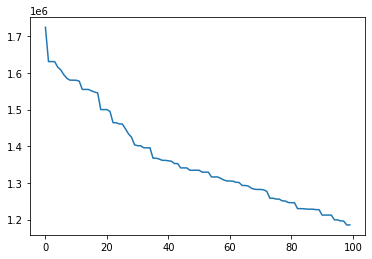

In [ ]:
plt.plot(range(len(hist_res)),hist_res);